## Problem 1: APT

### c)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Sharpe ratio')

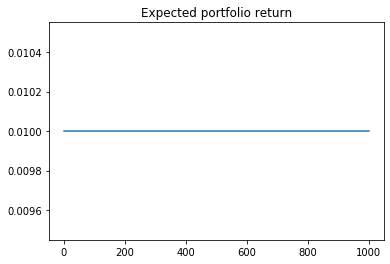

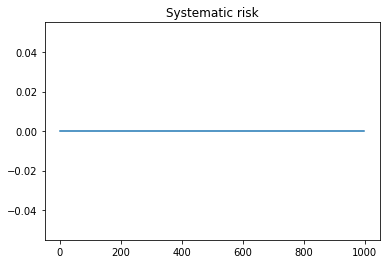

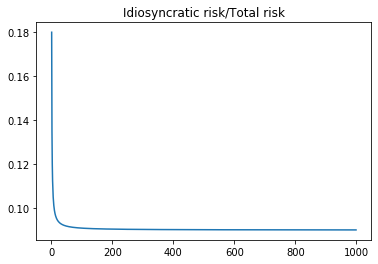

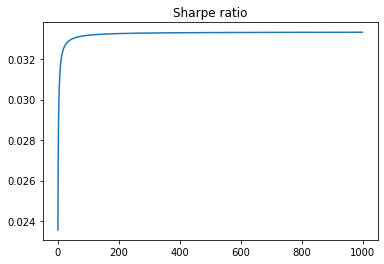

In [2]:
# parameters
alpha_b = 0.03
beta_b = 0.5
beta_a = 0.5
w_a = 0.5
mu_f = 0.08
sigma_b = 0.3
sigma_a = 0.3
r_0 = 0.04

N_A = np.arange(1,1000)

# # expected return of hedged portfolio
# R_h = alpha_b + beta_b * mu_f - w_a*mu_f
# # idiosyncratic risk of hedged portfolio
# u_h = sigma_b**2 + (1/4)*(sigma_a/beta_a)**2*N_A
# # systematic risk of hedged portfolio
# s_h = beta_b**2 - 1/4
# # total risk of hedged portfolio
# t_h = beta_b**2 + sigma_b**2 + 1/4 + (1/4)*(sigma_a/beta_a)**2*N_A
# # sharpe ratio of hedged portfolio
# sr_h = (R_h-r_0)/np.sqrt(t_h)

alpha_b = 0.03
beta_b = 0.5
beta_a = 0.5
w_a = 0.5
mu_f = 0.08
sigma_b = 0.3
sigma_a = 0.3
r_0 = 0.04

N_A = np.arange(1,1000)

#expected return of the portfolio
R_p = alpha_b - 0.5 * r_0
plt.figure()
plt.plot(N_A,R_p*np.ones(999))
plt.title("Expected portfolio return")
#systematic risk
s_p = 0
plt.figure()
plt.plot(N_A,s_p*np.ones(999))
plt.title("Systematic risk")
# idiosyncratic risk of hedged portfolio/total risk
u_p = 0.09 + 0.09/N_A
plt.figure()
plt.plot(N_A,u_p)
plt.title("Idiosyncratic risk/Total risk")
# Sharpe ratio
sh_p = 0.01/(np.sqrt(0.09+0.09/N_A))
plt.figure()
plt.plot(N_A,sh_p)
plt.title("Sharpe ratio")


### e)

Text(0.5, 1.0, 'Sharpe ratio')

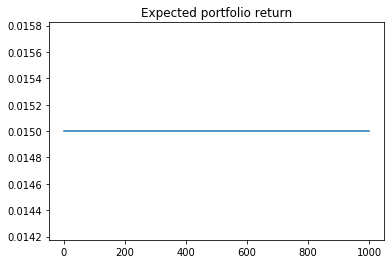

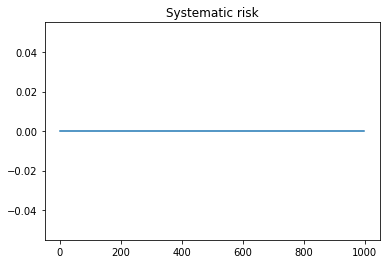

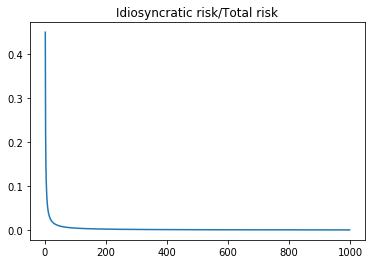

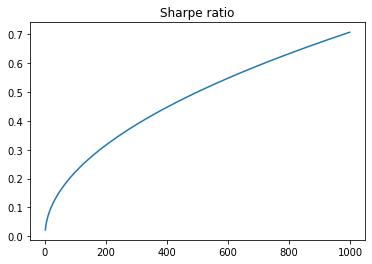

In [3]:
N = np.arange(1,1000)
#expected return of the portfolio
R_p = 0.015
plt.figure()
plt.plot(N,R_p*np.ones(999))
plt.title("Expected portfolio return")
#systematic risk
s_p = 0
plt.figure()
plt.plot(N,s_p*np.ones(999))
plt.title("Systematic risk")
# idiosyncratic risk of hedged portfolio/total risk
u_p = 0.45/N
plt.figure()
plt.plot(N,u_p)
plt.title("Idiosyncratic risk/Total risk")
# Sharpe ratio
sh_p = 0.015/(np.sqrt(0.45/N))
plt.figure()
plt.plot(N,sh_p)
plt.title("Sharpe ratio")


## Problem 2: Understanding Warren Buffett's Performance

In [3]:
import wrds
import pandas as pd

In [4]:
db = wrds.Connection()
db.create_pgpass_file()

Loading library list...
Done
Enter your WRDS username [jonkq]:jonkq
Enter your password:········


In [5]:
brk=db.raw_sql("select date, ret from crsp.msf where permno in (17778) and date>='1976-01-01' and date<='2019-12-31'")
brk.to_csv('brk.csv')

In [6]:
r0 = db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox=2000001 and mcaldt>='1976-09-01' and mcaldt<='2019-12-31'")
# brk starts at 1971-09 (not 1971-01)

In [7]:
# conformity check
len(r0) == len(brk)

True

In [8]:
dates = brk.date
brk = brk.ret

In [9]:
r0 = r0.tmytm.squeeze()

In [10]:
# simple monthly rates
r0 = (np.exp(r0/100)-1)/12

In [11]:
# create data frame
rets = pd.DataFrame({'brk':brk, 'r0':r0})
rets['date'] = dates
rets = rets.set_index('date')

In [12]:
# remove rows containing NaN
nan = rets.brk.isna()
nas = [i for i, x in enumerate(nan) if x]
nas = dates[nas]
rets = rets.drop(nas)

### b)

In [13]:
brk_m = 12*100*((rets.brk-rets.r0).mean())
brk_s = 100*np.sqrt(12)*((rets.brk-rets.r0).std())
print('Annualized excess returns\n\nMean: {:0.3}%\nStDev: {:0.3}%\nSharpe ratio: {:0.3}'.format(brk_m, brk_s, brk_m/brk_s))

Annualized excess returns

Mean: 18.2%
StDev: 23.2%
Sharpe ratio: 0.785


In [14]:
# fama-french factors
fff = pd.read_table('F-F_Research_Data_5_Factors_2x3.CSV', sep=',', index_col=0)
fff = fff/100

In [15]:
dates2 = list(fff.index)

In [16]:
x1 = list(range(13*12+4))
x2 = list(range(len(fff)-14,len(fff)))
x1 = [dates2[i] for i in x1]
x2 = [dates2[i] for i in x2]
fff = fff.drop(x1)
fff = fff.drop(x2)

In [17]:
# there are 3 missing months in rets
# drop them in fff

In [64]:
dates = list(rets.index)
dates = [dates[i].strftime('%Y-%m-%d') for i in  range(len(dates))]
dates3 = [dates[i].split('-')[0] + dates[i].split('-')[1] for i in range(len(dates))]

In [65]:
dates2 = list(fff.index)
dates3 = [int(dates3[i]) for i in range(len(dates3))]

In [66]:
mis = []

for i in range(518):
    if dates2[i] < dates3[i]:
        dates3.insert(i, dates2[i])
        mis.append(i)
    if dates3[i] < dates2[i]:
        dates2.insert(i, dates3[i])
        mis.append(i)

In [71]:
mis_dates = [dates2[i] for i in mis]
fff = fff.drop(mis_dates)

##### Fama-French

In [74]:
fff

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
197611,0.0036,0.0266,0.0151,-0.0139,0.0007,0.0040
197612,0.0565,0.0360,0.0220,-0.0062,0.0223,0.0040
197702,-0.0194,0.0111,0.0052,-0.0013,-0.0019,0.0035
197703,-0.0137,0.0129,0.0106,-0.0032,-0.0009,0.0038
197704,0.0015,0.0060,0.0344,-0.0205,0.0114,0.0038
...,...,...,...,...,...,...
201908,-0.0258,-0.0328,-0.0485,0.0042,-0.0089,0.0016
201909,0.0143,0.0024,0.0677,0.0199,0.0350,0.0018
201910,0.0206,0.0020,-0.0188,0.0025,-0.0099,0.0015


In [75]:
# sharpes

### c)

In [78]:
rets['brk_e'] = rets.brk-rets.r0

In [119]:
mom = pd.read_table('F-F_Momentum_Factor.CSV', sep=',', index_col=0)
mom = mom/100
mom = mom.drop(mis_dates)

In [80]:
from sklearn.linear_model import LinearRegression

In [164]:
Y = np.asarray(rets.brk_e)
alphas = []
betas = []
resid = []
r2 = []
X = np.array([fff['Mkt-RF'], fff.SMB, fff.HML, mom.squeeze(), fff.RMW, fff.CMA])
X = X.transpose()

In [165]:
for j in range(X.shape[1]):
    x = X[:,:j+1]
    fit = LinearRegression().fit(x,Y)
    alphas.append(fit.intercept_)
    betas.append(fit.coef_)
    r2.append(fit.score(x,Y))
    resid.append(Y-fit.predict(x))

In [155]:
alphas

[0.010540545504526717,
 0.010785876566691714,
 0.009026724369147119,
 0.008523074661185511,
 0.0069443831655455115,
 0.006975188230248428]

In [152]:
betas

[array([0.69294322]),
 array([ 0.74021652, -0.30512799]),
 array([ 0.82446237, -0.27136907,  0.50844583]),
 array([ 0.83640535, -0.27557777,  0.53338199,  0.06070191]),
 array([ 0.86748582, -0.15481063,  0.4772694 ,  0.03116522,  0.42371761]),
 array([ 0.86597504, -0.15451405,  0.48425876,  0.0319012 ,  0.42264091,
        -0.01519991])]